In [105]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy
from scipy.optimize import curve_fit
from ast import literal_eval

from climada.hazard.low_flow import LowFlow

from climada.entity import ImpactFunc, ImpactFuncSet
from climada.entity.exposures import Exposures
from climada.engine import Impact


# Old version to get impact functions with ISIMIP2b data --> see if_calibration_isimip2a.ipynb for the 'better' method

## Using ISIMIP2b to find impact functions based on historical events--> the dates do not actually corresponding to real events, based fully on discharge values:

### for that, we take historical events, see what the discharge reduction was during these events based on literature research. We then calculate for the given region what the percentage discharge is compare to the long term for a 2.5th percentile day. We finally get the number of days by estimating how many days this event would have to last to see the resulting reduction in yearly flow.

In [106]:
# function to buid impact function based on days instead of relativ flow.
# historical_data is a dataframe with containing some data points to build the function:
# these must at least be a bbox for the region, a yearly flow reduction from an event in %
# and the resulting yearly loss
# The other inputs are the same as to build a hazard.



def if_finder_isimip2b(histrorical_data, min_days_per_month, percentile, input_dir, gh_model, cl_model, \
                        fn_str_var= 'co2_dis_global_daily', scenario = 'historical',
                         soc = 'histsoc', yearrange=[1981,2005], yearrange_ref=[1981,2005]):
    
    
    
    ndays_list = []

    for index in [3]:  # loop through impact function data points
 
        bbox = literal_eval(historical_data['bbox'].iloc[index]) # area for which to calculate the hazards

        haz = LowFlow()

        haz.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                    cl_model=cl_model, scenario=scenario, soc=soc, keep_dis_data = True, min_days_per_month=min_days_per_month)
   
        
        discharge_reduction = float(historical_data[''.join(['discharge_reduction_',gh_model])].iloc[index]) # yearly discharge reduction
        loss = historical_data['loss'].iloc[index]
        
        # get the number of days that the event would have to last to get the equivalent yearly flow 
        # reduction 
        ndays = discharge_reduction/(1-haz.data['relative_dis'].mean())*365
        ndays_list.append(ndays)
        
    historical_data["_".join(['ndays',gh_model,cl_model])].iloc[3:4] = ndays_list
    return(historical_data)
        

In [114]:
historical_data = pd.read_excel('historical_data_isimip2b.xlsx')


In [ ]:
input_dir = '/home/zelie/Python_projects/low_flow/data/isimip_data/'

fn_str_var= 'co2_dis_global_daily'
scenario = 'historical'
soc = 'histsoc'
yearrange=[1981,2005]
yearrange_ref=[1981,2005]
min_days_per_month=5
percentile = 2.5

for gh_model in ['h08']:#,'lpjml','matsiro']:
    for cl_model in ['hadgem2-es','gfdl-esm2m','miroc5','ipsl-cm5a-lr']:
                historical_data = if_finder_isimip2b(historical_data, min_days_per_month, percentile, input_dir, gh_model, cl_model)

In [115]:
historical_data

,Focus,Region,bbox,discharge_reduction_lpjml,discharge_reduction_h08,discharge_reduction_matsiro,loss,ndays_lpjml_gfdl-esm2m,ndays_lpjml_hadgem2-es,ndays_lpjml_miroc5,...,ndays_h08_hadgem2-es,ndays_h08_miroc5,ndays_h08_ipsl-cm5a-lr,ndays_matsiro_gfdl-esm2m,ndays_matsiro_hadgem2-es,ndays_matsiro_miroc5,ndays_matsiro_ipsl-cm5a-lr,lpjml,h08,matsiro
0,Hydro,Spain,"[-9, 36, 0, 43]",0.400,0.400,0.400,0.360,147.625905,147.153541,147.607884,...,159.124142,163.780676,157.424331,184.410263,177.053534,184.392716,174.695545,147.363721,160.491618,180.138015
1,Hydro,California,"[-121, 32, -113, 41]",0.380,0.380,0.380,0.500,163.623890,151.276405,161.996647,...,195.940772,189.757309,196.820995,156.690320,155.150555,154.344929,156.649328,158.465328,193.213337,155.708783
2,Nuclear,Elbe,"[8, 49, 16, 57]",0.207,0.207,0.207,0.121,80.348232,79.268436,80.723487,...,98.831779,99.605056,103.315537,147.732579,137.900041,146.357900,173.733146,80.379709,100.567825,151.430917
3,Nuclear,Germany,"[6, 47, 15, 54]",0.440,0.110,0.440,0.115,169.812189,167.439366,170.805988,...,204.786512,205.390865,213.131782,374.807637,349.537848,363.360542,427.864268,170.430173,206.982833,378.892574
4,Hydro,Central Europe,"[6, 47, 25, 54]",0.250,0.200,0.126,0.066,96.070088,95.494352,96.911725,...,93.593194,95.841213,101.082347,95.781287,86.520399,94.987540,104.482942,46.431381,57.931433,90.898135
5,Nuclear,Central Europe,"[6, 47, 25, 54]",0.250,0.200,0.126,0.047,96.070088,95.494352,96.911725,...,93.593194,95.841213,101.082347,95.781287,86.520399,94.987540,104.482942,46.431381,57.931433,90.898135


In [ ]:
historical_data['lpjml'] = historical_data.iloc[:,5:9].mean(axis=1)

historical_data['h08'] = historical_data.iloc[:,9:13].mean(axis=1)

historical_data['matsiro'] = historical_data.iloc[:,13:17].mean(axis=1)

In [116]:
hydro_if = historical_data[historical_data['Focus']=='Hydro']
thermo_if = historical_data[historical_data['Focus']!='Hydro']


lpjm and h08 hydro models combined with the 4 climate models, these look like we can make a common if, the points are quite close for all combinations

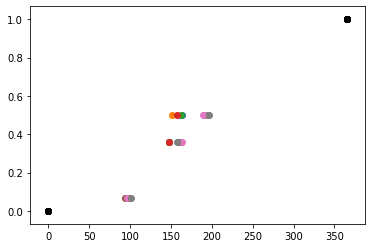

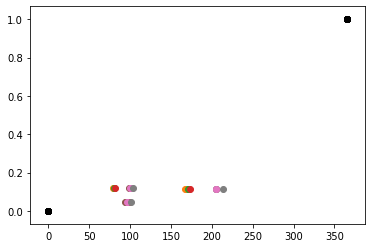

In [117]:

fig,ax = plt.subplots()
for gh_model in ['lpjml','h08']:
    for cl_model in ['gfdl-esm2m','hadgem2-es','miroc5','ipsl-cm5a-lr']:
        ax.scatter(hydro_if["_".join(['ndays',gh_model,cl_model])],hydro_if['loss'])
        ax.scatter([0,365],[0,1],color='black')                
        
fig,ax = plt.subplots()
for gh_model in ['lpjml','h08']:
    for cl_model in ['gfdl-esm2m','hadgem2-es','miroc5','ipsl-cm5a-lr']:
        ax.scatter(thermo_if["_".join(['ndays',gh_model,cl_model])],thermo_if['loss'])
        ax.scatter([0,365],[0,1],color='black')
        
 #the points in black would be assumptions       

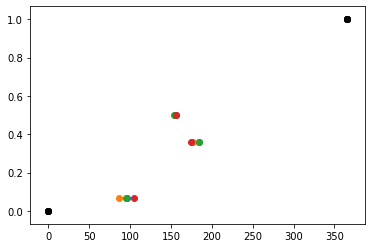

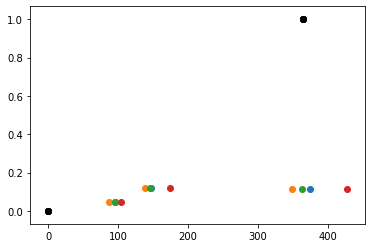

In [118]:
fig,ax = plt.subplots()
for gh_model in ['matsiro']:
    for cl_model in ['gfdl-esm2m','hadgem2-es','miroc5','ipsl-cm5a-lr']:
        ax.scatter(hydro_if["_".join(['ndays',gh_model,cl_model])],hydro_if['loss'])
        ax.scatter([0,365],[0,1],color='black')                
        
fig,ax = plt.subplots()
for gh_model in ['matsiro']:
    for cl_model in ['gfdl-esm2m','hadgem2-es','miroc5','ipsl-cm5a-lr']:
        ax.scatter(thermo_if["_".join(['ndays',gh_model,cl_model])],thermo_if['loss'])
        ax.scatter([0,365],[0,1],color='black')
        
#the points in black would be assumptions

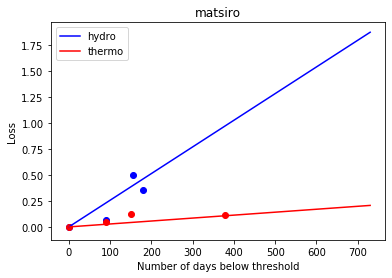

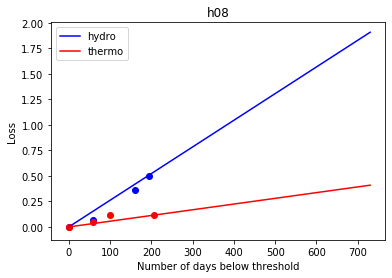

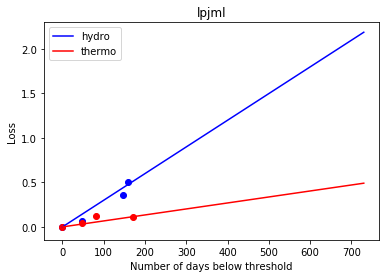

In [148]:
isimip2a_isimip2b_slopes = pd.read_excel('slopes_isimip2a_isimip2b.xlsx')

hydro = historical_data[historical_data['Focus']=='Hydro']
thermo = historical_data[historical_data['Focus']!='Hydro']


col = {'thermo':'Red', 'hydro':'blue'}

data = {'thermo':thermo,'hydro':hydro}
if_slopes = {}

for h_model in ['h08','lpjml', ]:
    fig, ax = plt.subplots()
    if_slopes[h_model] = {}
    for technology in ['hydro','thermo']:
        n = [0]+list(data[technology][h_model])
        d = [0]+list(data[technology]['loss'])

        x0 = np.linspace(0,365*2,100)
        s = np.polyfit(n,d,1)[0]
        
        isimip2a_isimip2b_slopes[''.join([technology,'_isimip2b'])][isimip2a_isimip2b_slopes['gh_model']==h_model]=s
        
        if_slopes[h_model][technology] = s
        ax.plot(x0,s*x0,color = col[technology],label=technology)
        ax.scatter(n,d,color = col[technology])
        ax.set_xlabel('Number of days below threshold')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.set_title(" ".join([h_model]))
        

In [155]:
isimip2a_isimip2b_slopes.to_excel('slopes_isimip2a_isimip2b.xlsx')
